Online state estimation for random walk example
===
This demo implements the state estimation for a random walk with Gaussian noise. Along the way we will use the `wrap` concept and make use of write buffers. 

Let our estimation of the state $X[n]$ be a univariate Gaussian distribution with mean $m$ and variance $V$ at time index $n$. At each consecutive timestep we update $X[n]$ by adding a constant Gaussian noise `N`, with mean `m_noise` and variance `V_noise`. We want to estimate the mean and variance for `X` at a final timestep `n=n_steps`. 

```
           [N]
            |   
    X[n-1]  v  X[n]
   ------->[+]----->
```

We start by including the ForneyLab.jl toolbox and initializing these basic settings.

In [1]:
# Load PyPlot and ForneyLab.jl
using PyPlot
using ForneyLab

# Basic settings
n_steps = 50  # Total number of timesteps.
m_noise = 0.0 # Mean of the noise, corresponds with a drift of X.
V_noise = 1.0 # Variance of the Gaussian noise.
X_0     = DeltaDistribution(0.0) # Initial setting for the state X at n=0;

INFO: Loading help data...


The graph we will construct models one step in the random walk process. There are two ways to set up the nodes. Either initialize one timestep and feed the output back to the input, or build a chain by initializing all timesteps and connecting them to form the complete graph. We will choose the first option in this demo.

In [2]:
# Initialize and connect nodes
PriorNode(X_0, id=:X_n_min_1) # Initial state
TerminalNode(id=:X_n)
PriorNode(GaussianDistribution(m=m_noise, V=V_noise), id=:N) # Constant noise
AdditionNode(id=:add)

Edge(n(:X_n_min_1), n(:add).i[:in1])
Edge(n(:N), n(:add).i[:in2])
Edge(n(:add).i[:out], n(:X_n));

Now we need to indicate that the output at the right is actually the input for the next section. We do so by defining a `Wrap`:

In [3]:
Wrap(n(:X_n), n(:X_n_min_1));

Now when we visualize the graph, we notice the green arrow indicating the presence of wrap in time.

In [4]:
draw()

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.36.0 (20140111.2315)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 13565957563970782468 -->
 13565957563970782468 
 
 X_n 
 
<!-- 410999656010575757 -->
 410999656010575757 
 
 X_n_min_1 
 
<!-- 13565957563970782468->410999656010575757 -->
 13565957563970782468->410999656010575757 
 
 
 
<!-- 10974747928394194146 -->
 10974747928394194146 
 
 + 
 add 
 
<!-- 10974747928394194146->13565957563970782468 -->
 10974747928394194146->13565957563970782468 
 
 
 FW: ○ 
 BW: ○ 
 Distribution: Any 
 1 out 
 3 out 
 
<!-- 410999656010575757->10974747928394194146 -->
 410999656010575757->10974747928394194146 
 
 
 FW: ○ 
 BW: ○ 
 Distribution: Any 
 1 in1 
 1 out 
 
<!-- 8242493557467973559 -->
 8242493557467973559 
 
 N 
 
<!-- 8242493557467973559->10974747928394194146 -->
 8242493557467973559->10974747928394194146 
 
 
 FW: ○ 
 BW: ○ 
 Distribution: Any 
 2 in2 
 1 out

The quantity we are interested in is the state of `x`. We can tell ForneyLab to store the online state estimate for each timepoint by initializing a write buffer.

In [5]:
X = attachWriteBuffer(n(:add).i[:out]);

We also need to define an inference algorithm. With the write buffer set, `SumProduct.Algorithm()` will automatically initialize a sumproduct algorithm that passes messages towards the wraps and write buffers defined on the graph.

In [6]:
algo = SumProduct.Algorithm()

Algorithm with fields:
 schedule::Array{ScheduleEntry,1}

Use algorithm.fields[:field] to inspect field values.


Now our graph is ready for state estimation. We call the `step()` function on our algorithm `n_steps` times. Each call to `step()` executes the schedule, writes to the buffer and resets the graph for the next step.

In [7]:
for n = 1:n_steps
    step(algo)
end

Our calculated state has been written to our buffer. We can extract the mean and standard deviation and plot the result.

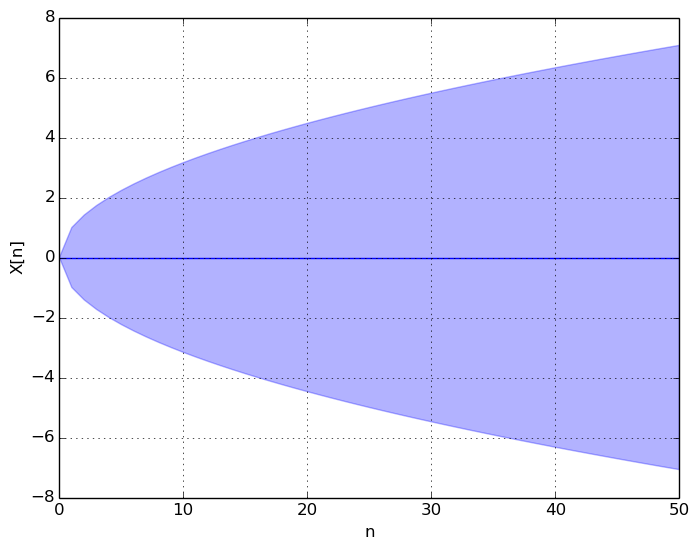

In [8]:
# Extract mean and standard deviation
X_means = [mean(X_n)[1] for X_n in [X_0, X]]
X_sds = [sqrt(var(X_n)[1,1]) for X_n in [X_0, X]]

# Make plot
plot([0:n_steps], X_means, "b-")
fill_between([0:n_steps], X_means-X_sds, X_means+X_sds, color="b", alpha=0.3)
xlabel("n")
ylabel("X[n]")
grid(true)

#Sampling a random walk path

Instead of estimating the expectation over all paths as in the previous section, we can also sample data from the model by drawing a sample after each step. For this we need to specify a `sample()` post-processing operation at the end of each section.

Note that we do not alter the graph structure but simply construct a new sumproduct algorithm with an altered schedule.

In [9]:
# Define a new algorithm and edit the schedule entry that should draw a sample
clearMessages!()
algo2 = SumProduct.Algorithm()
schedule = algo2.fields[:schedule]
setPostProcessing!(schedule, n(:X_n).i[:out].partner, sample) # Specify the sample function as post-processing
show(schedule)

Message passing schedule (entry: node [interface], rule)
------------------------------------------------------
1: TerminalNode X_n_min_1 [1:out], sumProduct! 
2: TerminalNode N [1:out], sumProduct! 
3: AdditionNode add [3:out], sumProduct! sample


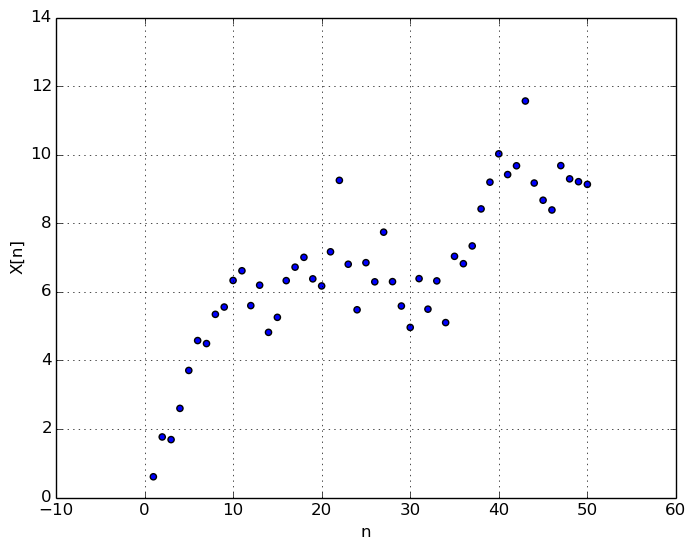

In [10]:
# Reset the starting point and write buffers
n(:X_n_min_1).value = X_0
emptyWriteBuffers()

# Execute the mew schedule
for n = 1:n_steps
    step(algo2)
end

# Plot the samples
X_vals = [mean(X_n)[1] for X_n in X]
scatter(1:n_steps, X_vals)
xlabel("n")
ylabel("X[n]")
grid(true)